## Libraries and Constants

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img, to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

import pickle

In [2]:
img_height = 100
img_width = 100
num_classes = 84
base_dir = '../data/dataset'

## Functions

#### Load Data

In [3]:
def resize_without_squeezing(image, target_size):
    h, w = image.shape[:2]
    aspect_ratio = w / h
    if aspect_ratio > 1:
        new_w = target_size
        new_h = int(target_size / aspect_ratio)
    else:
        new_h = target_size
        new_w = int(target_size * aspect_ratio)
    resized_img = cv2.resize(image, (new_w, new_h))
    canvas = np.full((target_size, target_size, 3), (255,255,255), dtype=np.uint8)
    y_offset = (target_size - new_h) // 2
    x_offset = (target_size - new_w) // 2
    canvas[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized_img
    return canvas

def get_folders_in_directory(directory_path):
    # Get the list of all files and folders in the specified directory
    items = os.listdir(directory_path)
    # Filter out only the folders from the list
    folders = [item for item in items if os.path.isdir(os.path.join(directory_path, item))]
    return folders
    
def load_images_from_folder(folder):
    # Function to load and preprocess images from a folder
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = resize_without_squeezing(img,img_height)
            images.append(img)
    return images

def load_images(dir):
    labels_name = get_folders_in_directory(dir) # get the list of folder names
    labels_dict1 = {label:i for i,label in enumerate(labels_name)} # assign an int for each folder name = asana
    labels_dict2 = {i:label for i,label in enumerate(labels_name)}

    # Get all images and corresp labels
    all_images=[]
    all_labels=[]
    for label in labels_name:
        new_images = load_images_from_folder(dir+'/'+label)
        all_images = all_images + new_images
        for i in range(len(new_images)):
            all_labels.append(labels_dict1[label])

    # Ensure that all_image_paths and all_labels are numpy arrays for easier manipulation
    images = np.array(all_images)/255 # normalize images to the range [0-1]
    labels = np.array(all_labels)

    # Shuffle indices and use the shuffled indices to reorder X and y
    indices = np.arange(len(images))
    np.random.shuffle(indices)
    images_shuffled = images[indices]
    labels_shuffled = labels[indices]

    return images_shuffled, labels_shuffled, labels_dict2

#### Splitting Data

In [4]:
def split(images, labels):
    # Split the dataset into training and temporary sets (combined validation and test)
    train_data, temp_data, train_labels, temp_labels = train_test_split(
        images, labels, test_size=0.3, random_state=42)
    
    # Split the temporary set into validation and test sets
    val_data, test_data, val_labels, test_labels = train_test_split(
        temp_data, temp_labels, test_size=0.5, random_state=42)
    
    train_labels_one_hot = to_categorical(train_labels, num_classes=num_classes)
    val_labels_one_hot = to_categorical(val_labels, num_classes=num_classes)
    test_labels_one_hot = to_categorical(test_labels, num_classes=num_classes)

    return train_data, train_labels_one_hot, val_data, val_labels_one_hot, test_data, test_labels_one_hot
    

#### Models

In [5]:
# Initialising the ImageDataGenerator class.
datagen = ImageDataGenerator(
        rotation_range = 30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip = True
)

In [6]:
def compile_model(model, optimizer, metrics):
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)
    return model

def save_model(model,path):
    with open(path, 'wb') as f:
        pickle.dump(model, f)

def import_model(path):
    with open(path, 'rb') as f:
        model = pickle.load(f)
    return model

In [7]:
def train_model(train_data, train_labels, val_data, val_labels, test_data, test_labels, model_type, optimizer, batch_size, num_epochs, metrics=['accuracy']):

    result_dict = {}
    result_dict["model"] = model_type
    result_dict["optimizer"] = optimizer
    result_dict["num_epochs"] = num_epochs
    result_dict["batch_size"] = batch_size
   
    if model_type == 'CNN':
        model = create_CNN()
    elif model_type == 'DenseNet':
        model = create_DN2()
        
    # optimizer
    initial_learning_rate = 0.001
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True)
    if optimizer=='adam':
        opt = keras.optimizers.Adam(learning_rate=lr_schedule)
    elif optimizer=='rmsprop':
        opt = keras.optimizers.RMSprop(learning_rate=lr_schedule)
    elif optimizer=='sgd':
        opt = keras.optimizers.SGD(learning_rate=lr_schedule)

    # compile model
    model = compile_model(model, opt, metrics)

    # train model
    early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.001, verbose=1, patience = 5, restore_best_weights=True)

    train_datagen = datagen.flow(train_data, train_labels, batch_size=batch_size)
    val_datagen = datagen.flow(val_data, val_labels, batch_size=batch_size)
    history = model.fit(train_datagen, epochs=num_epochs, callbacks=[early_stopping], validation_data=val_datagen)

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_data, test_labels)
    print(f'Test accuracy: {test_acc}')

    result_dict["actual_num_epochs"] = len(history.history['loss'])
    result_dict["accuracy"] = test_acc
    return result_dict, model

In [8]:
def train_all(param_grid, train_data, train_labels, val_data, val_labels, test_data, test_labels,save_path):
    results = []
    i=0
    best_accuracy = (-1,0)

    for model_type in param_grid['model']:
        for n_ep in param_grid['epochs']:
            for b_size in param_grid["batch_size"]:
                for opt in param_grid['optimizer']:
                    print(f"number of epochs: {n_ep}, batch size: {b_size}, optimizer: {opt}")
                    d, model = train_model(train_data, train_labels, val_data, val_labels, test_data, test_labels, 
                                    model_type, opt, b_size, n_ep, metrics=['accuracy'])
                    results.append(d)
                    if d["accuracy"] > best_accuracy[1]:
                        best_accuracy = (i,d["accuracy"])
                        save_model(model,save_path)
                    i+=1  
    return results

##### CNN

In [9]:
def create_CNN():
    model = keras.Sequential([
        layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.2), #to avoid overfitting
        
        layers.Conv2D(32, (3, 3), padding='same',  activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.2),
        
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.2),
        
        layers.Flatten(),
        #layers.Dense(512, activation='relu'), #prova anche 256 e 1024
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax') 

        #plot_model(model, to_file='CNNmodel_architecture.png', show_shapes=True, show_layer_names=True)
        
    ])
    
    return model

##### DenseNet

In [10]:
def create_DN():
    ptrain_model = tf.keras.applications.DenseNet121(input_shape=(img_height,img_width,3),
                                                      include_top=False,
                                                      weights='imagenet',
                                                      pooling='avg')
    ptrain_model.trainable = False
    
    inputs = ptrain_model.input

    # Trying different configurations, such as [512, 256], [256, 128], etc., could be beneficial.
    drop_layer = tf.keras.layers.Dropout(0.25)(ptrain_model.output)
    x_layer = tf.keras.layers.Dense(512, activation='relu')(drop_layer)
    x_layer1 = tf.keras.layers.Dense(128, activation='relu')(x_layer)
    drop_layer1 = tf.keras.layers.Dropout(0.20)(x_layer1)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(drop_layer1)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    #plot_model(model, to_file='DNmodel_architecture.png', show_shapes=True, show_layer_names=True)
    
    return model 

In [11]:
def create_DN2():
    # adding BatchNormalization
    ptrain_model = tf.keras.applications.DenseNet121(input_shape=(img_height,img_width,3),
                                                      include_top=False,
                                                      weights='imagenet',
                                                      pooling='avg')
    ptrain_model.trainable = False
    
    inputs = ptrain_model.input

    # Trying different configurations, such as [512, 256], [256, 128], etc., could be beneficial.
    drop_layer = tf.keras.layers.Dropout(0.25)(ptrain_model.output)
    x_layer = tf.keras.layers.Dense(512, activation='relu')(drop_layer)
    x_layer = tf.keras.layers.BatchNormalization()(x_layer)
    
    x_layer1 = tf.keras.layers.Dense(256, activation='relu')(x_layer)
    x_layer1 = tf.keras.layers.BatchNormalization()(x_layer1)
    
    drop_layer1 = tf.keras.layers.Dropout(0.20)(x_layer1)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(drop_layer1)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    #plot_model(model, to_file='DNmodel_architecture.png', show_shapes=True, show_layer_names=True)
    
    return model 

In [13]:
def create_DN3():
    # adding BatchNormalization
    ptrain_model = tf.keras.applications.DenseNet121(input_shape=(img_height,img_width,3),
                                                      include_top=False,
                                                      weights='imagenet',
                                                      pooling='avg')
    ptrain_model.trainable = False
    
    inputs = ptrain_model.input

    # Trying different configurations, such as [512, 256], [256, 128], etc., could be beneficial.
    drop_layer = tf.keras.layers.Dropout(0.25)(ptrain_model.output)
    x_layer = tf.keras.layers.Dense(512, activation='relu')(drop_layer)
    x_layer = tf.keras.layers.BatchNormalization()(x_layer)
    
    x_layer1 = tf.keras.layers.Dense(256, activation='relu')(x_layer)
    x_layer1 = tf.keras.layers.BatchNormalization()(x_layer1)

    x_layer2 = tf.keras.layers.Dense(128, activation='relu')(x_layer1)
    x_layer2 = tf.keras.layers.BatchNormalization()(x_layer2)
    
    drop_layer1 = tf.keras.layers.Dropout(0.20)(x_layer2)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(drop_layer1)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    #plot_model(model, to_file='DNmodel_architecture.png', show_shapes=True, show_layer_names=True)
    
    return model 

#### Save Results

In [14]:
def save_training_results(new_results_list):
    try:
        training_df = pd.read_csv('../data/training_table.cvs')
        result_df = pd.DataFrame(new_results_list)
        new_training_df = pd.concat([training_df, new_results_list]).reset_index(drop=True)
        new_training_df.to_csv("../data/training_table.cvs", index=False)
    except:
        result_df = pd.DataFrame(new_results_list)
        result_df.to_csv("../data/training_table.cvs", index=False)

#### ROC curve

In [15]:
def ROC_curve(model, test_labels_one_hot, labels_dict):
    y_true = test_labels_one_hot
    y_pred_prob = model.predict(test_data)

    # Calculate ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curve for each class
    plt.figure(figsize=(6, 3)) # Add more colors as needed
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], color='red', lw=2, label='Class {0} (AUC = {1:0.2f})'.format((i,labels_dict[i]), roc_auc[i]))
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
        plt.legend(loc="lower right")
        # plt.savefig(path)
        plt.show()

## 'main'

In [16]:
# load data
images, labels, labels_dict = load_images(base_dir)

In [17]:
# split data
train_data, train_labels, val_data, val_labels, test_data, test_labels = split(images, labels)

###### DenseNet

In [27]:
# try different models/parameters
param_grid = {
    'model' : ['DenseNet'],
    'epochs' : [30,50],
    'batch_size': [8,16,32],
    'optimizer': ['adam','rmsprop','sgd']}

dn_path = '../models/dn_best.pkl'
results_training = train_all(param_grid,train_data, train_labels, val_data, val_labels, test_data, test_labels, dn_path)

number of epochs: 30, batch size: 8, optimizer: adam
Epoch 1/30
337/337 [==============================] - 46s 115ms/step - loss: 4.2737 - accuracy: 0.0675 - val_loss: 3.5490 - val_accuracy: 0.1334
Epoch 2/30
337/337 [==============================] - 35s 103ms/step - loss: 3.4251 - accuracy: 0.1540 - val_loss: 3.0234 - val_accuracy: 0.2357
Epoch 3/30
337/337 [==============================] - 35s 104ms/step - loss: 3.1012 - accuracy: 0.2037 - val_loss: 2.7901 - val_accuracy: 0.2496
Epoch 4/30
337/337 [==============================] - 34s 102ms/step - loss: 2.9228 - accuracy: 0.2412 - val_loss: 2.5823 - val_accuracy: 0.2894
Epoch 5/30
337/337 [==============================] - 35s 104ms/step - loss: 2.7676 - accuracy: 0.2709 - val_loss: 2.4836 - val_accuracy: 0.3241
Epoch 6/30
337/337 [==============================] - 34s 100ms/step - loss: 2.6859 - accuracy: 0.2757 - val_loss: 2.4663 - val_accuracy: 0.3310
Epoch 7/30
337/337 [==============================] - 33s 99ms/step - loss: 2

In [57]:
save_training_results(results_training)

19/19 [==============================] - 7s 193ms/step


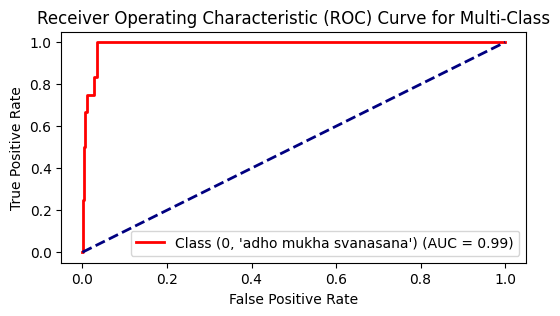

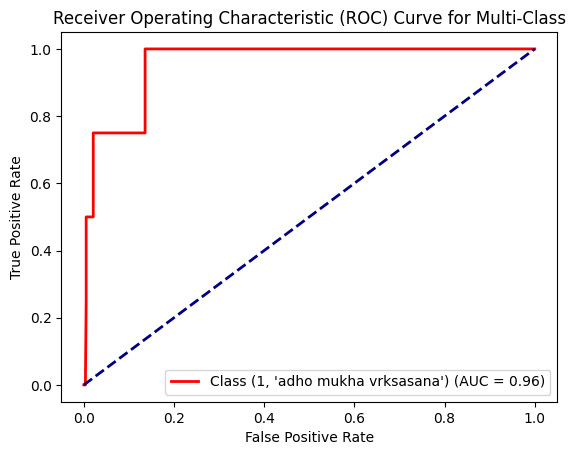

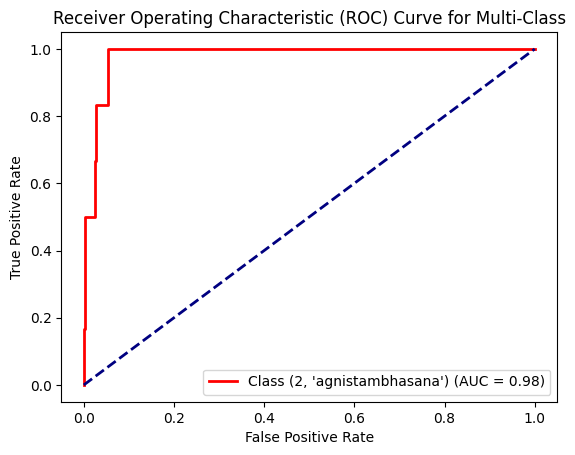

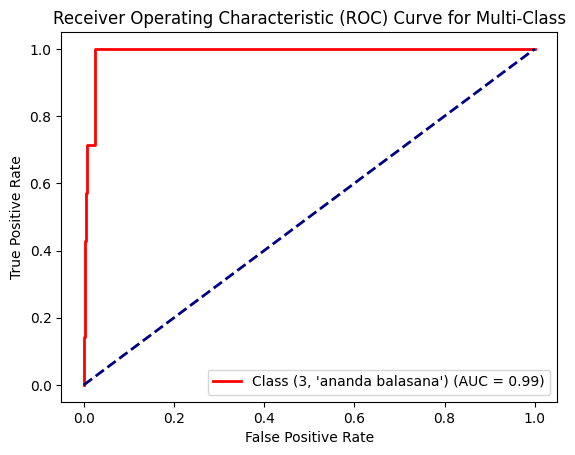

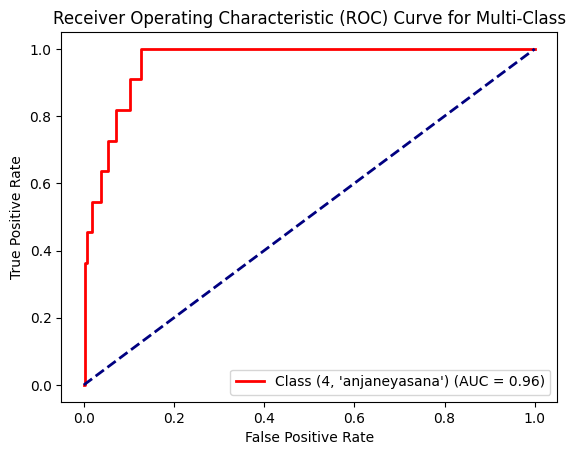

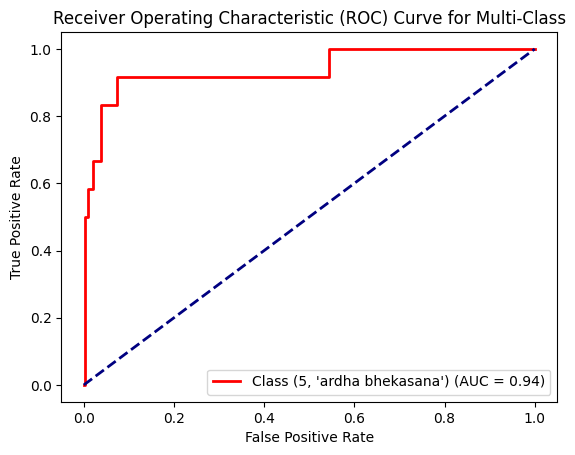

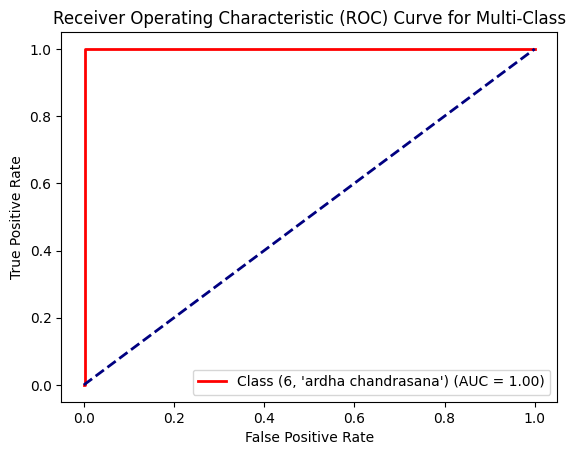

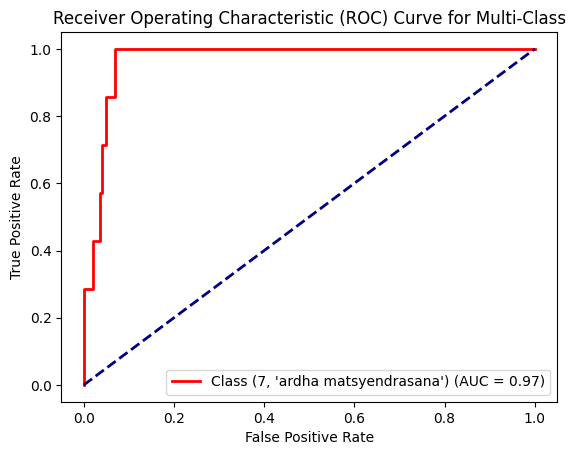

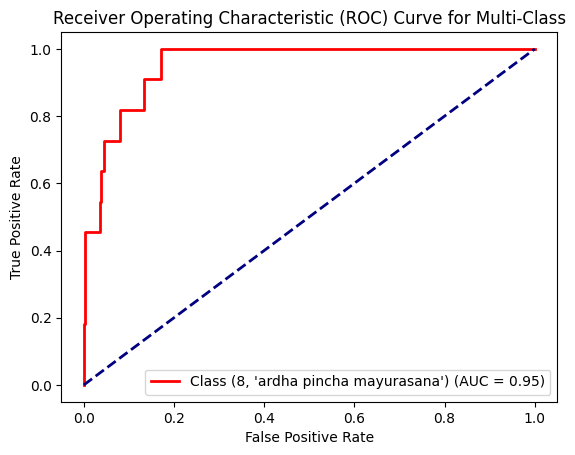

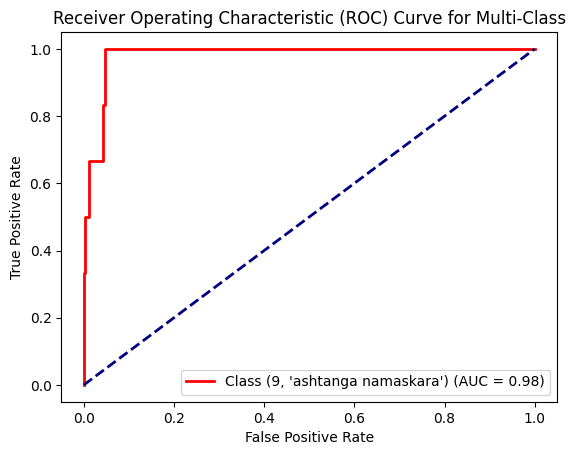

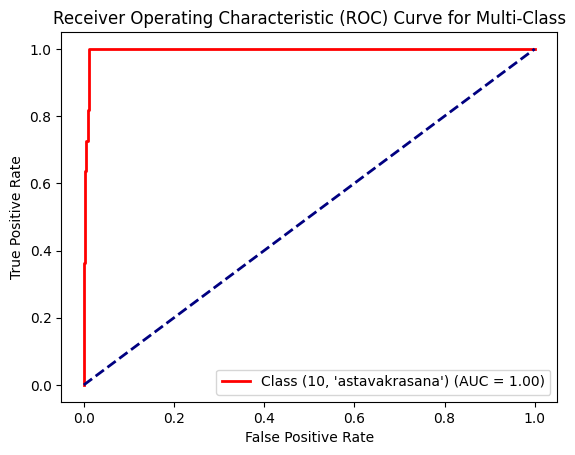

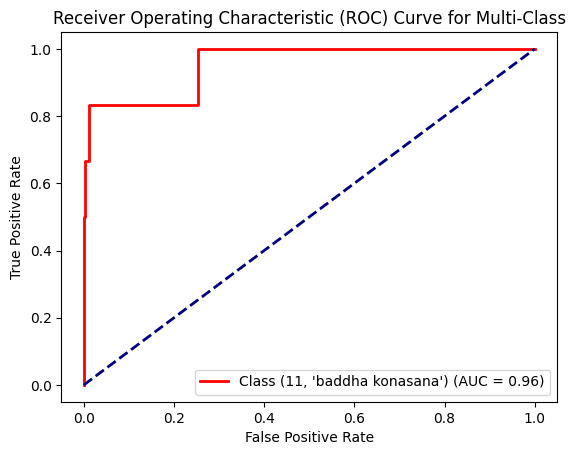

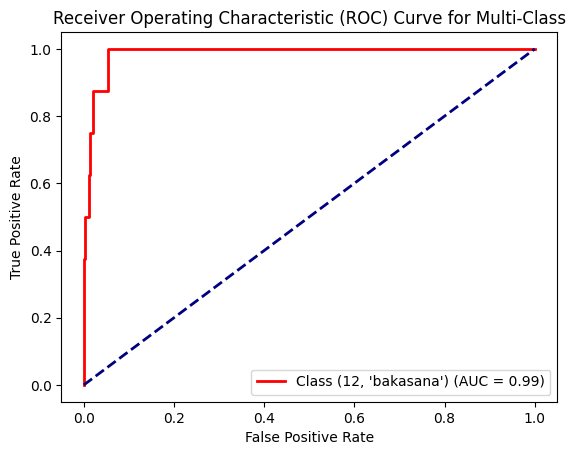

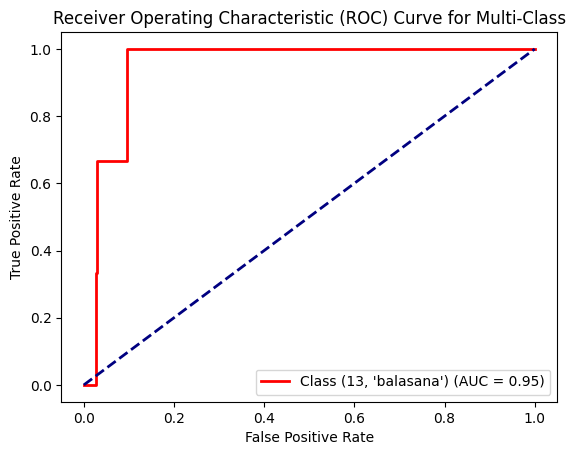

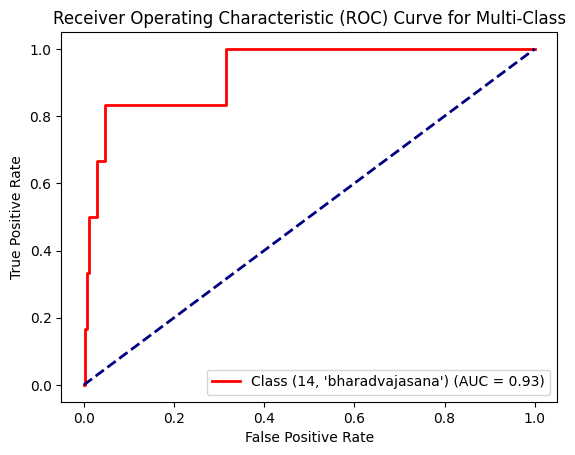

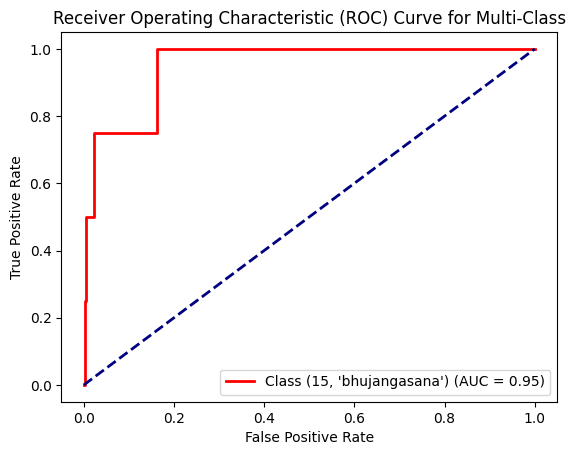

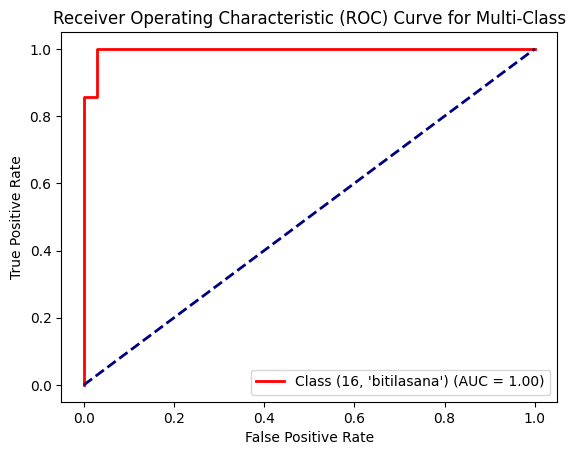

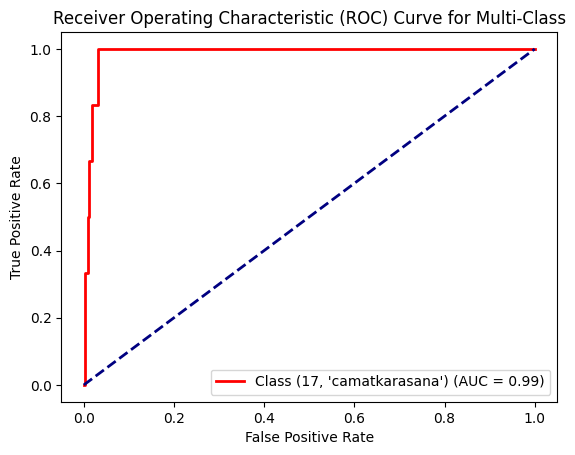

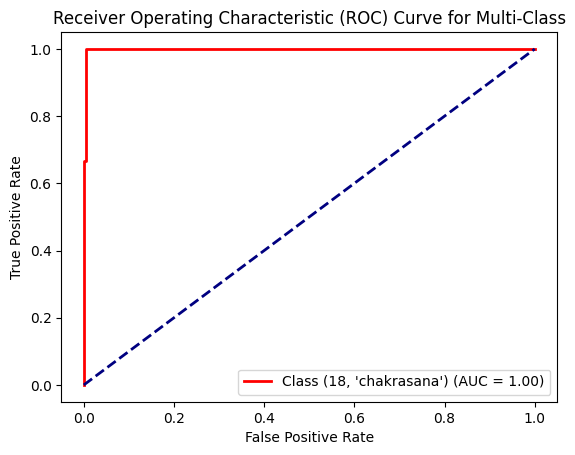

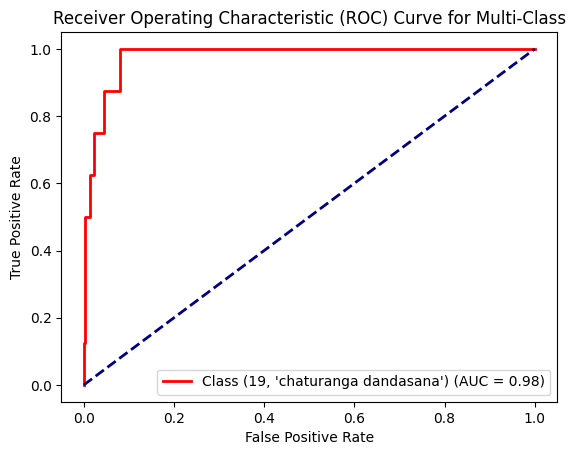

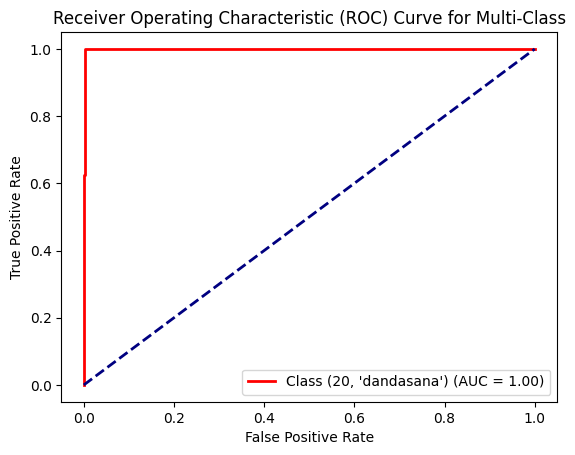

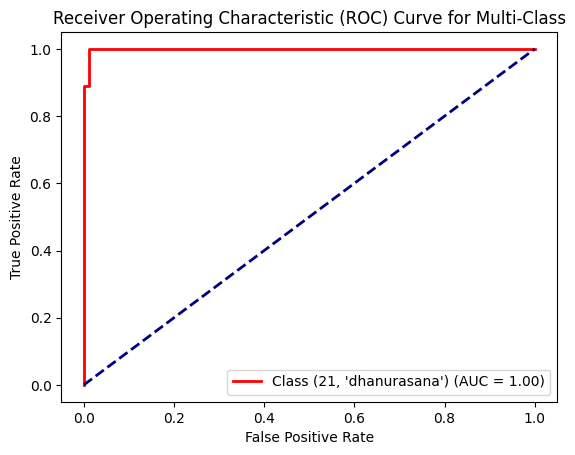

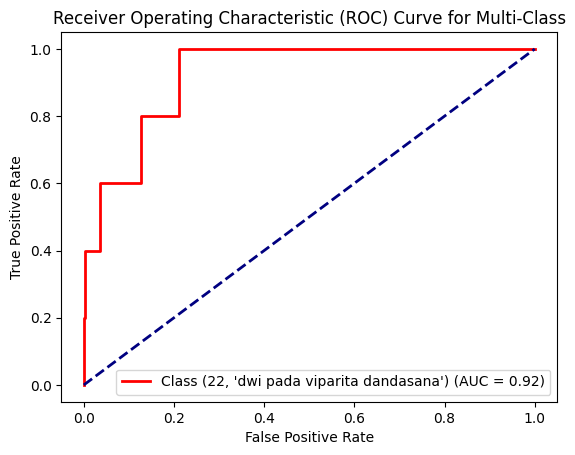

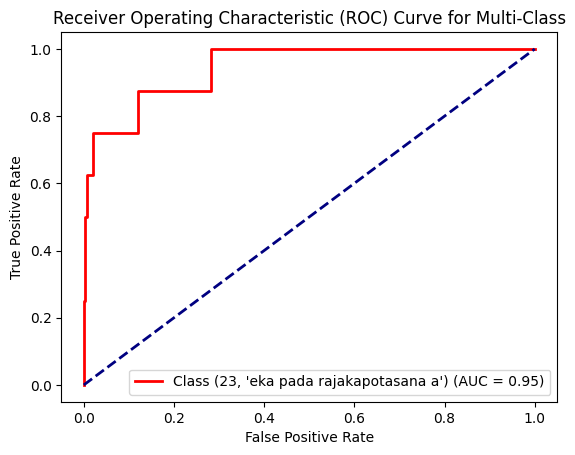

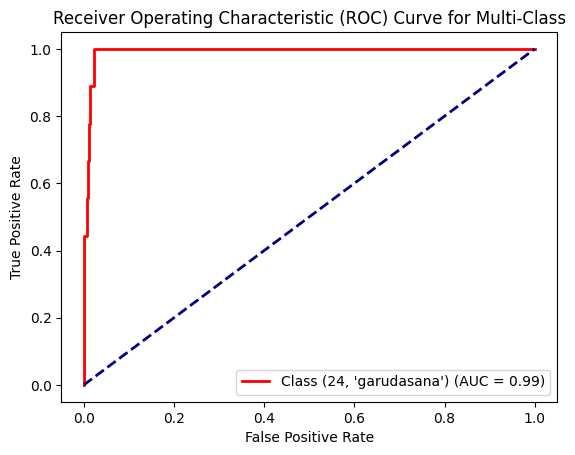

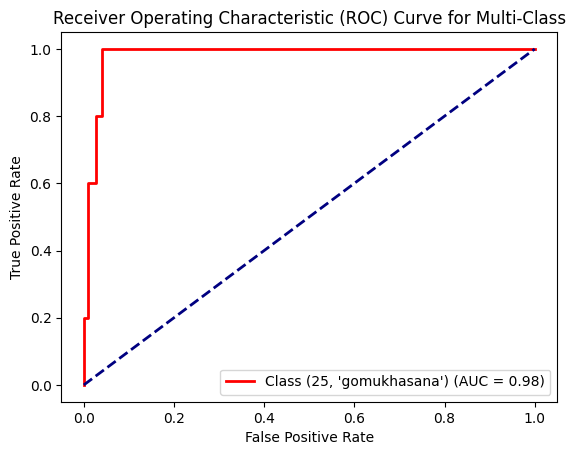

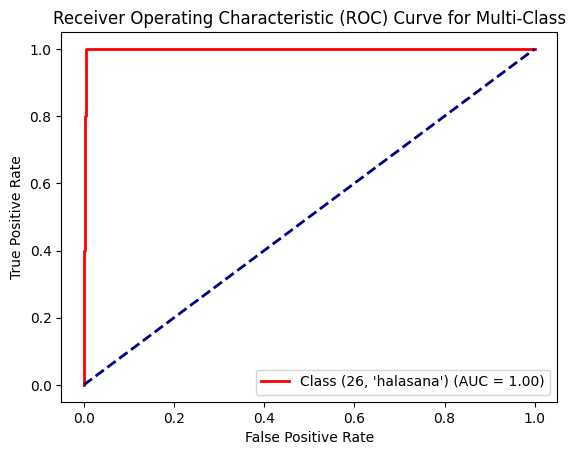

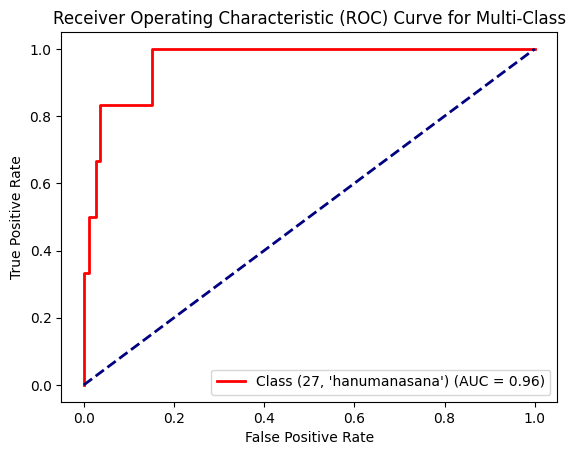

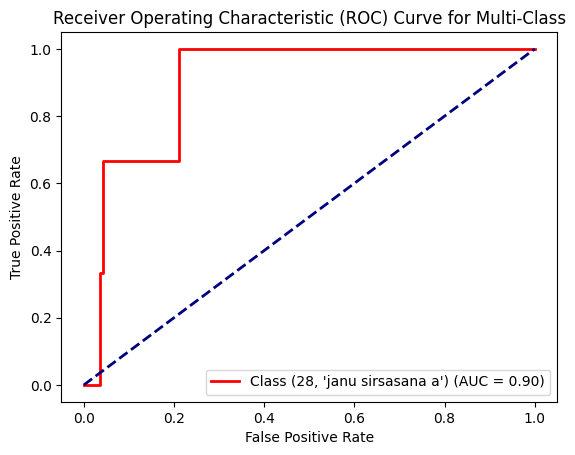

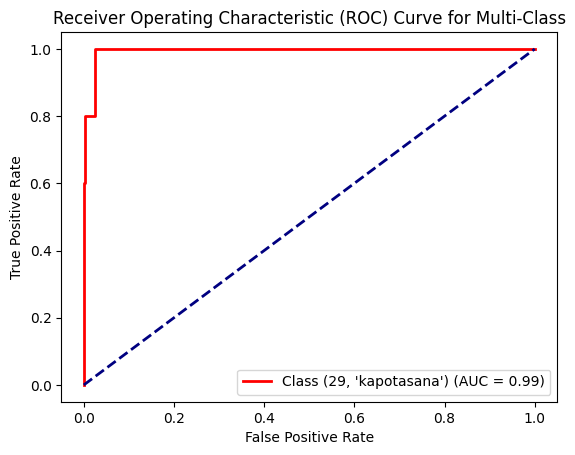

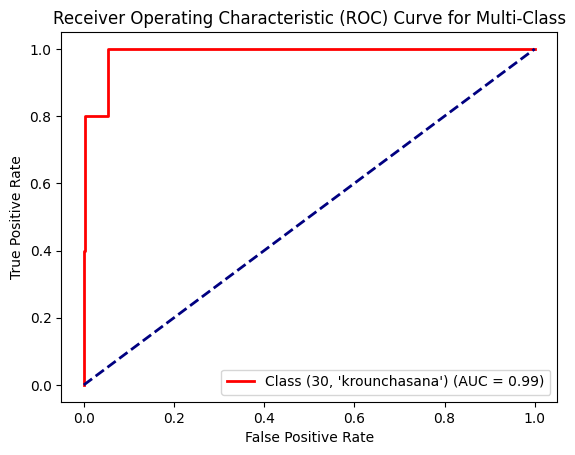

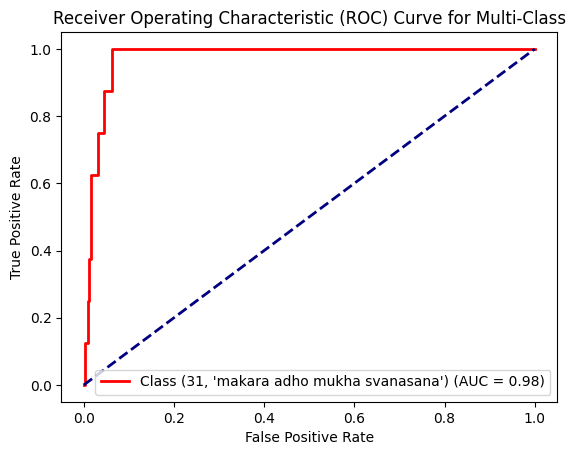

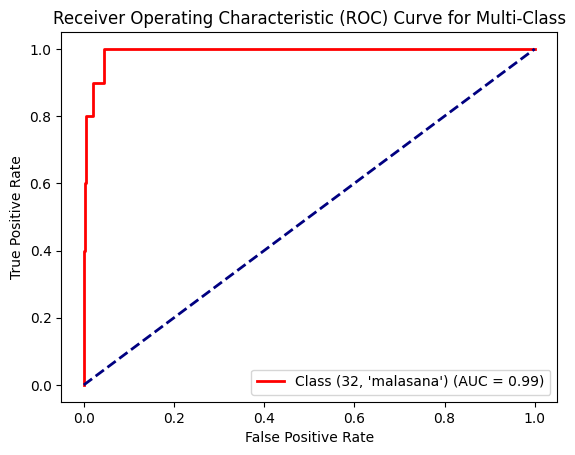

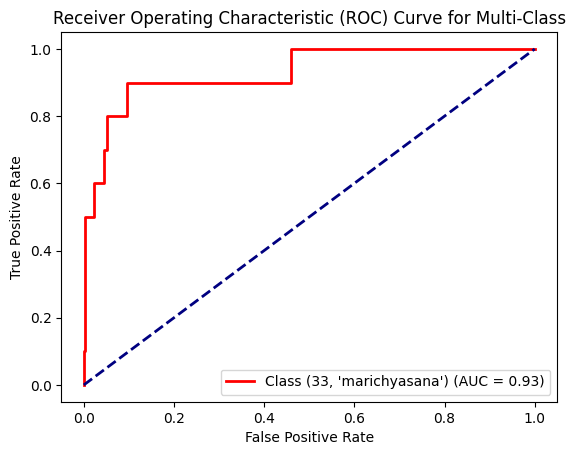

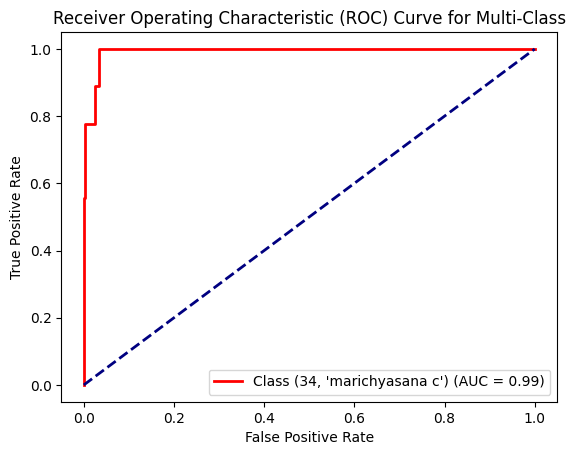

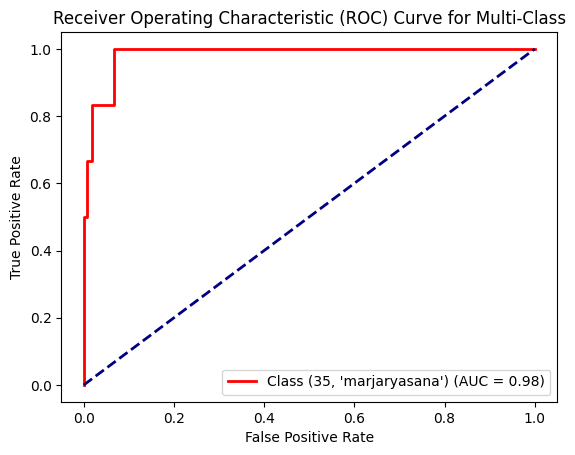

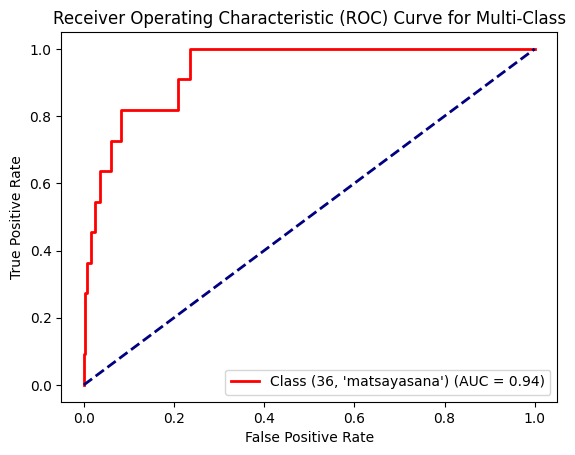

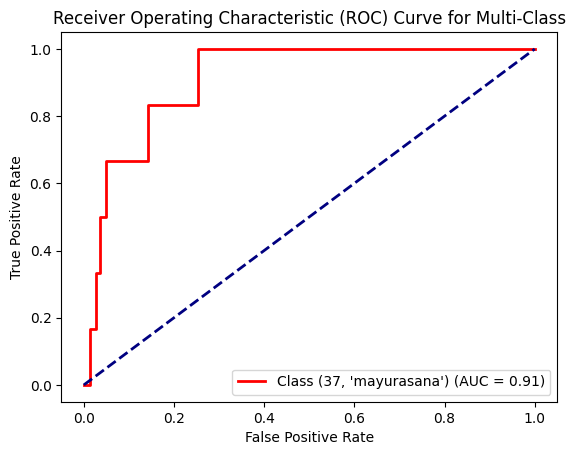

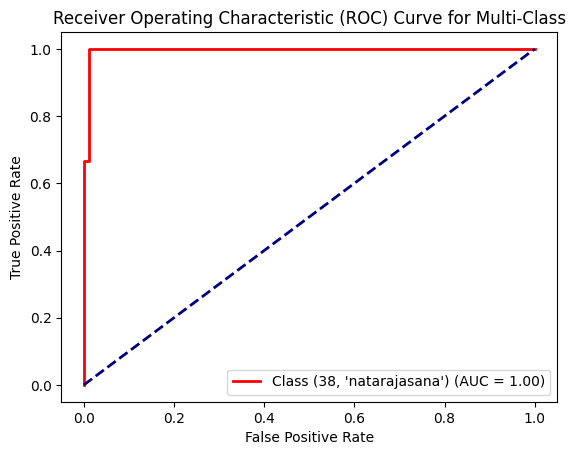

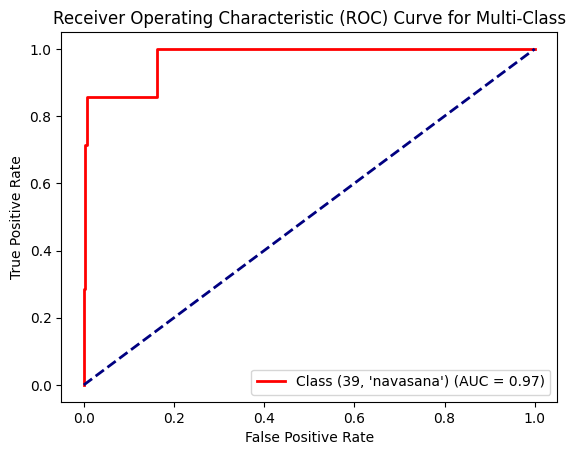

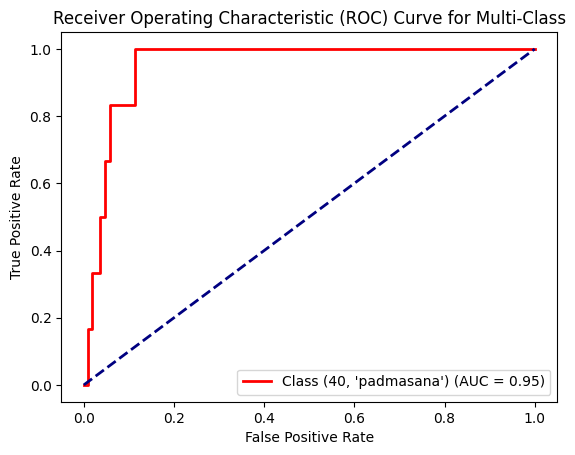

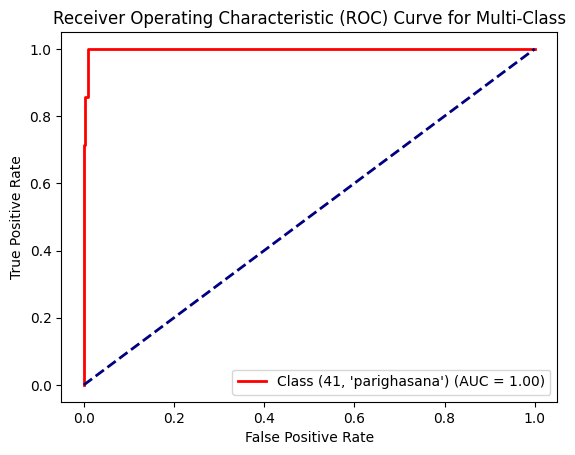

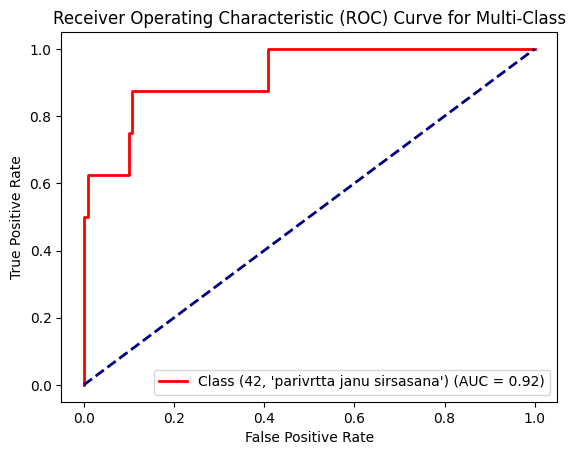

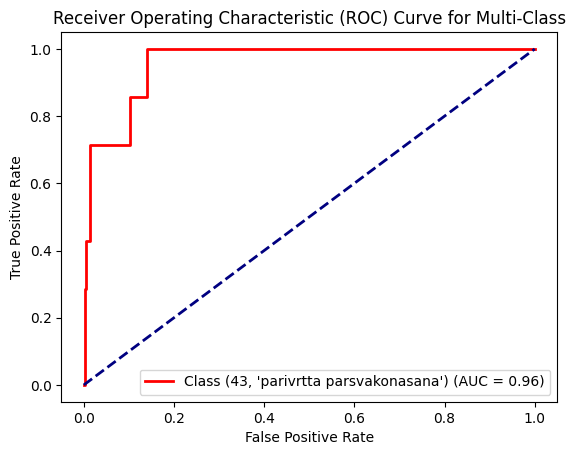

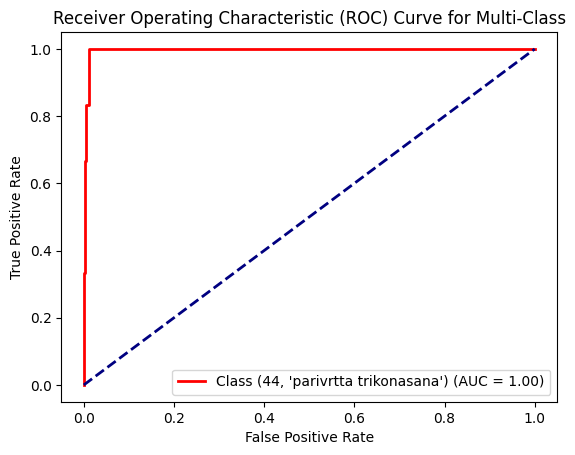

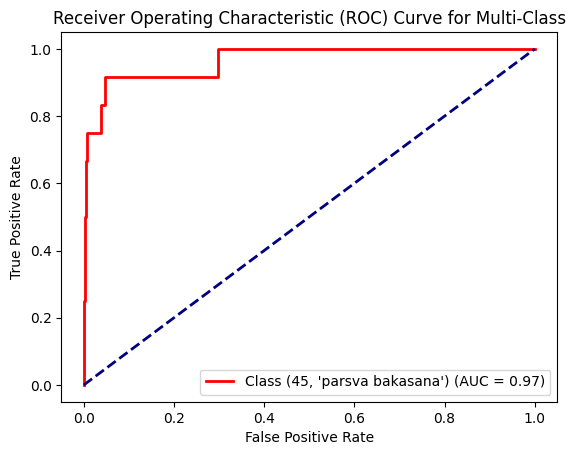

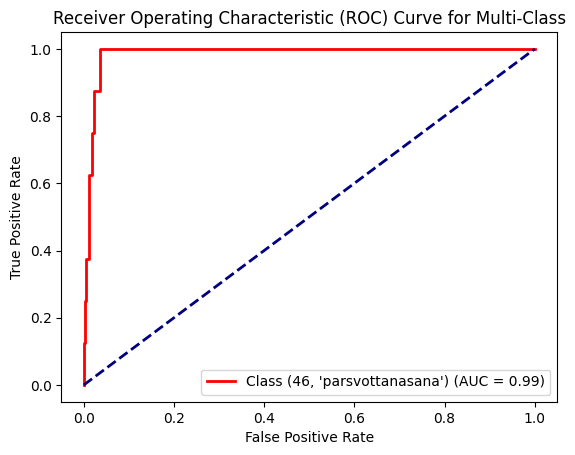

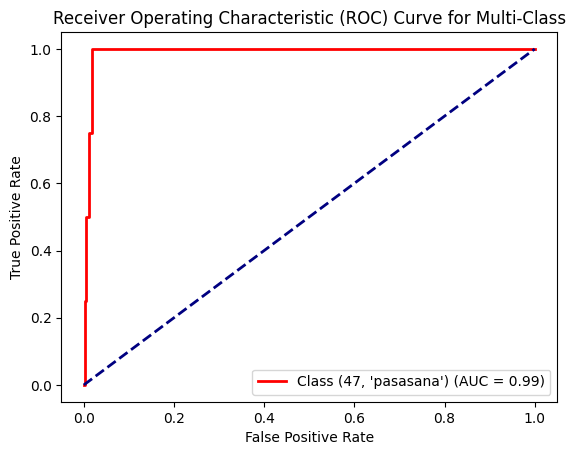

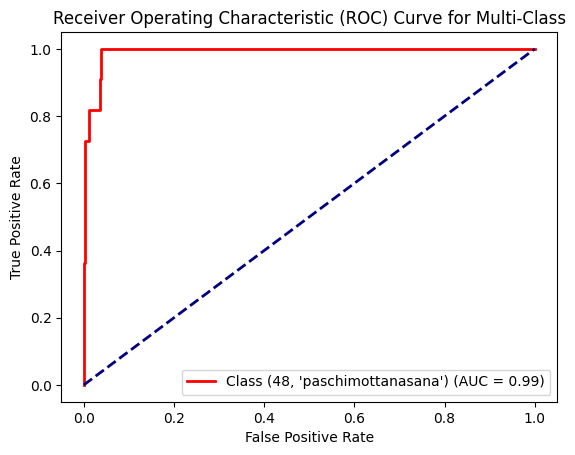

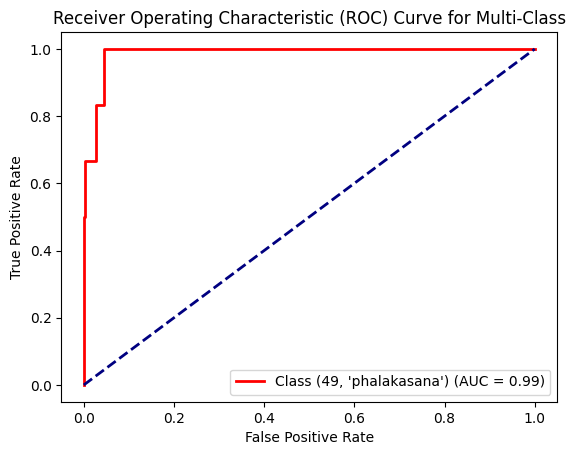

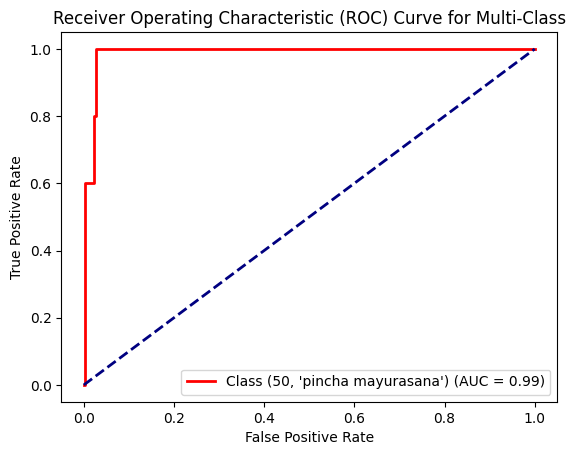

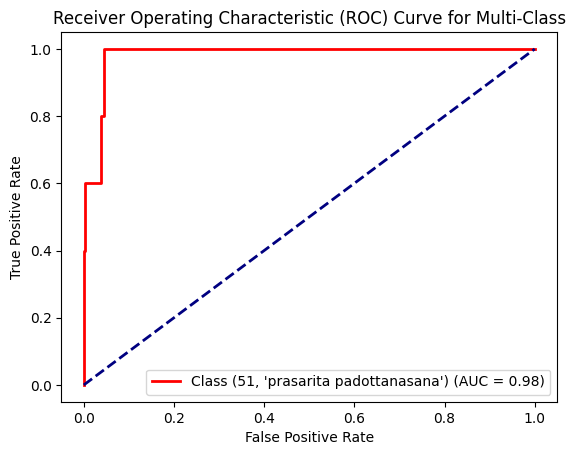

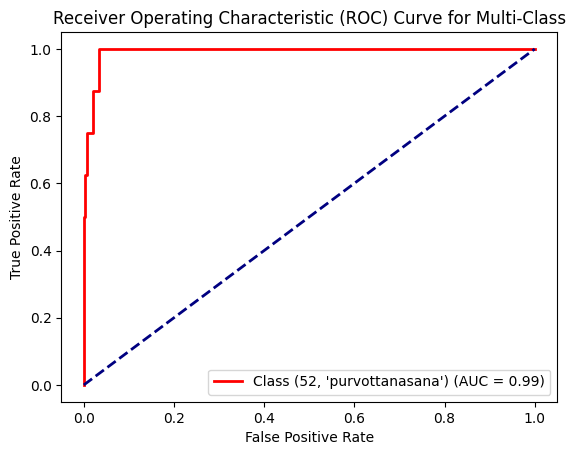

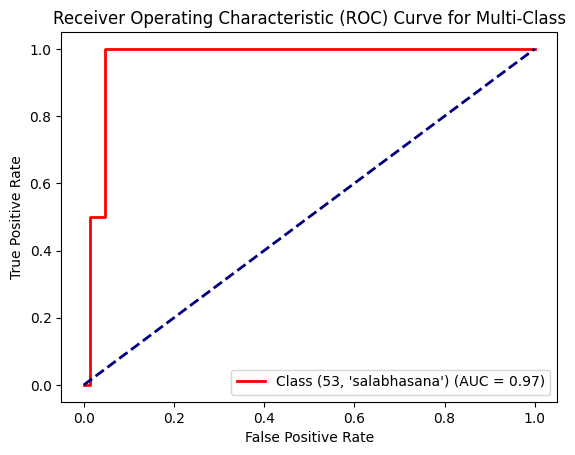

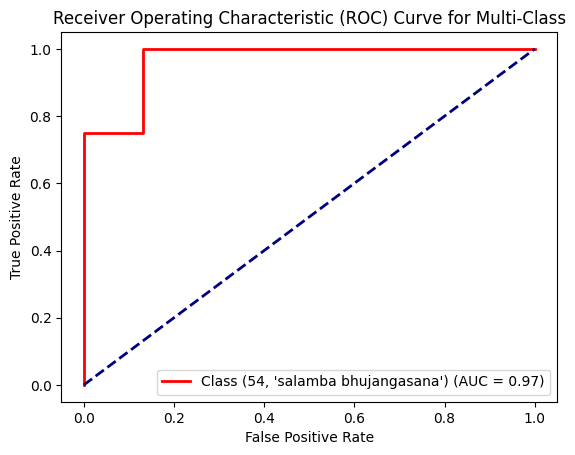

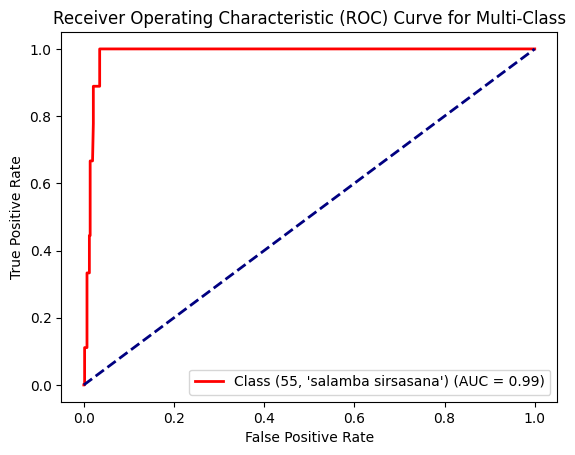

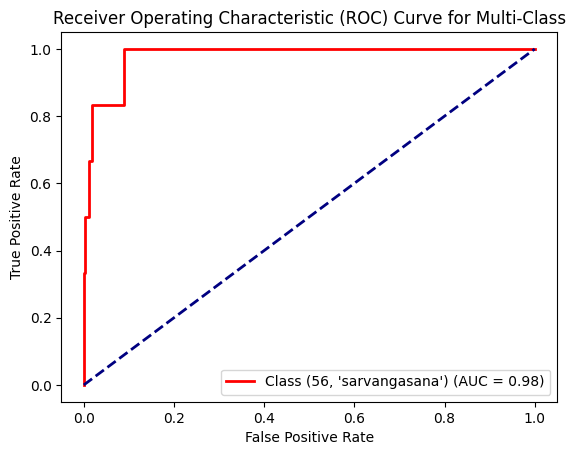

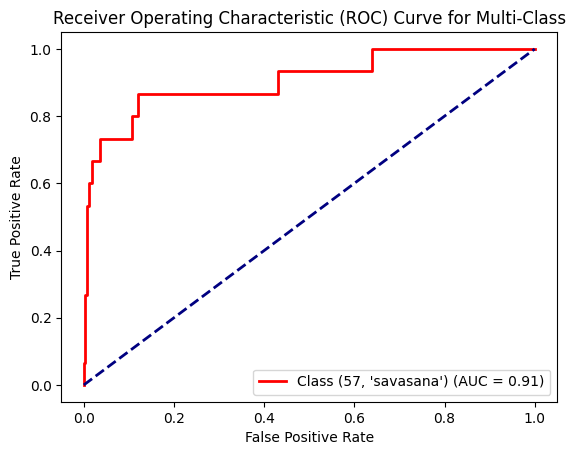

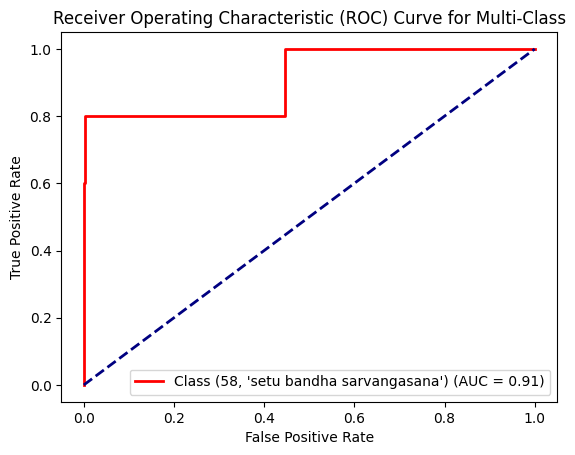

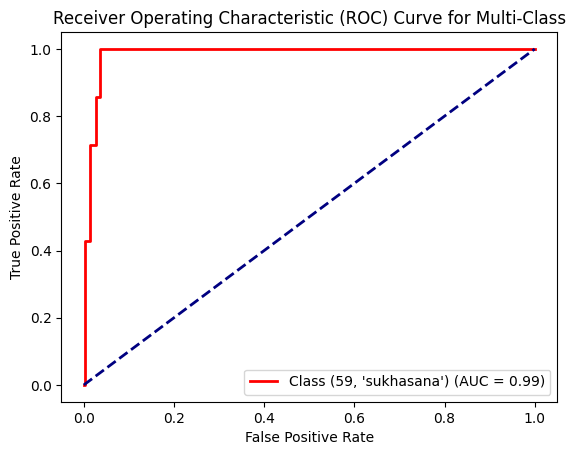

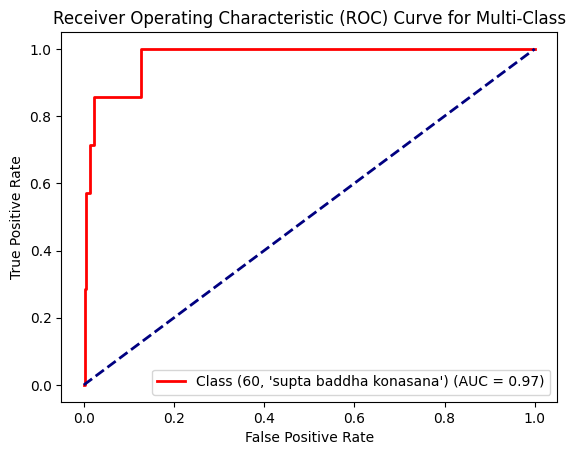

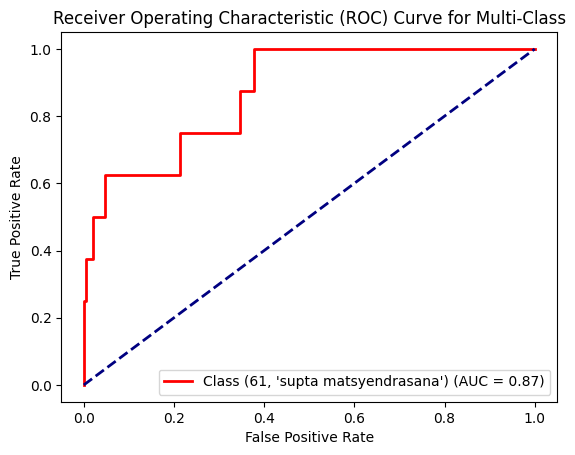

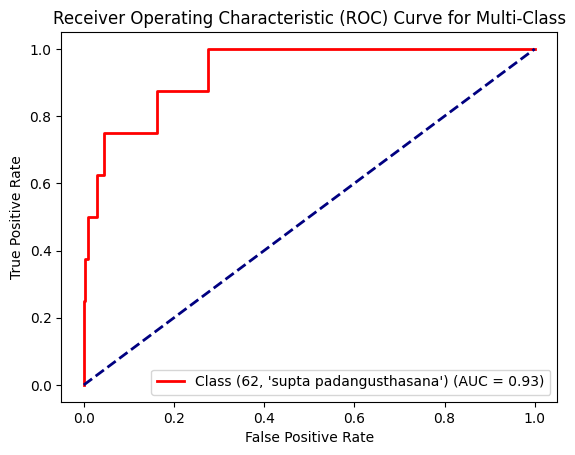

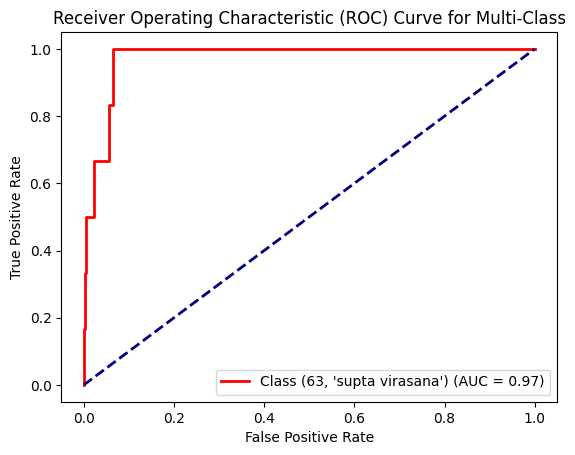

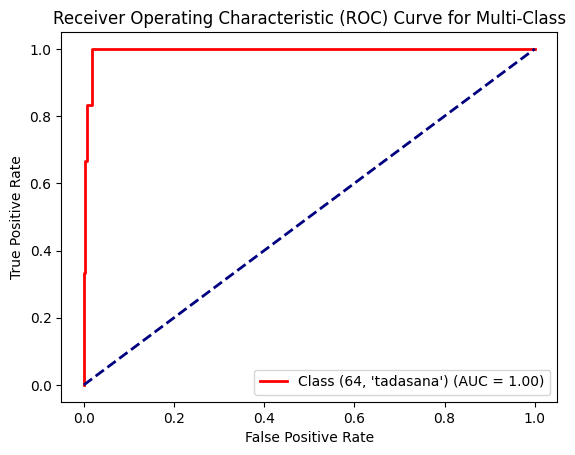

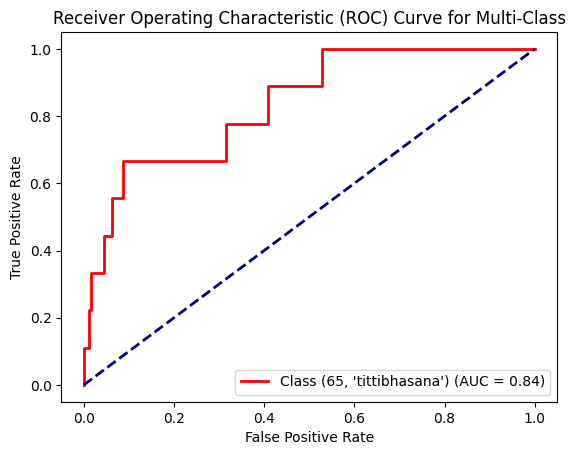

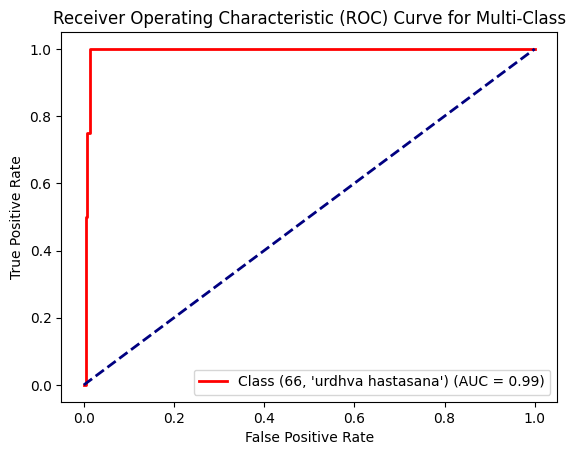

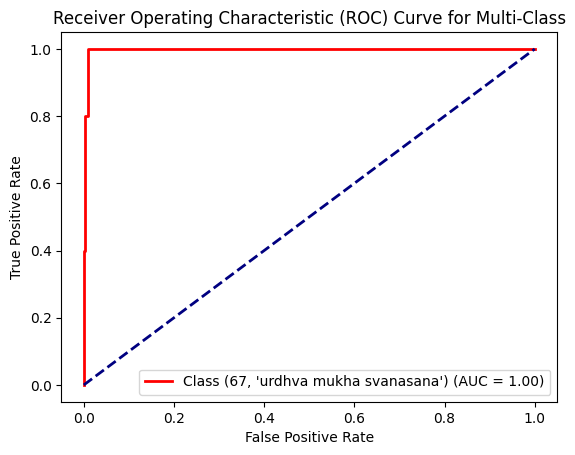

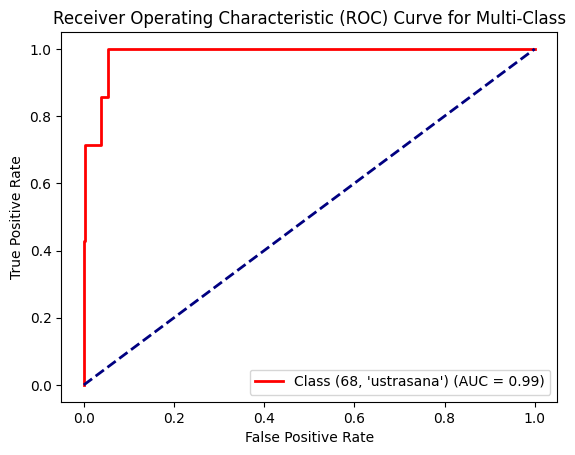

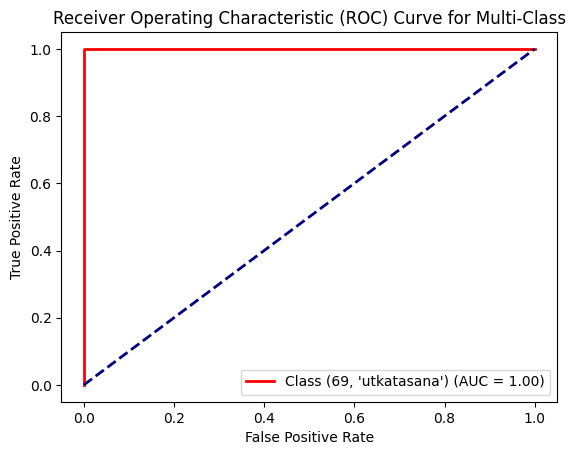

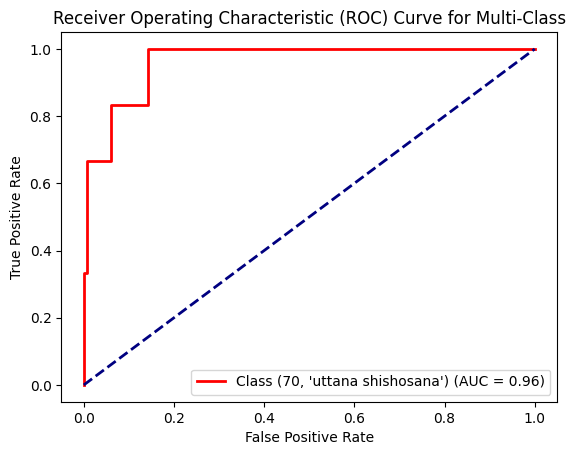

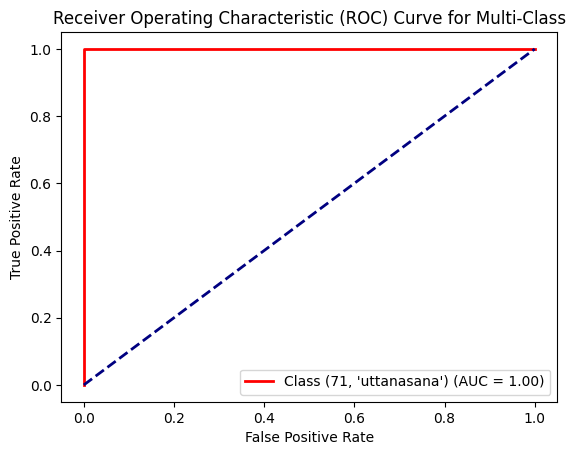

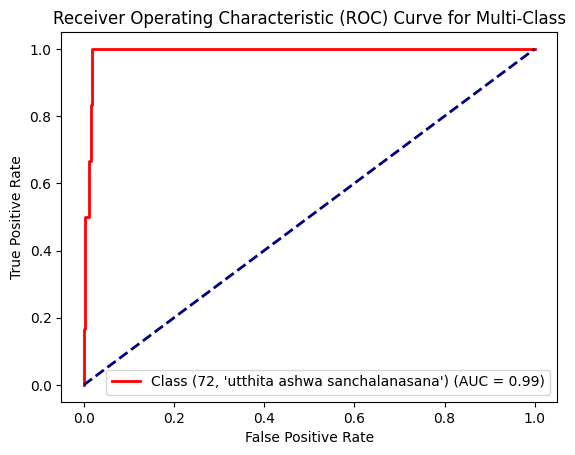

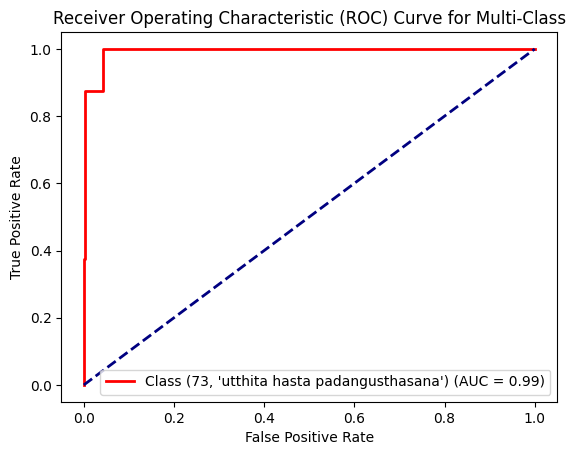

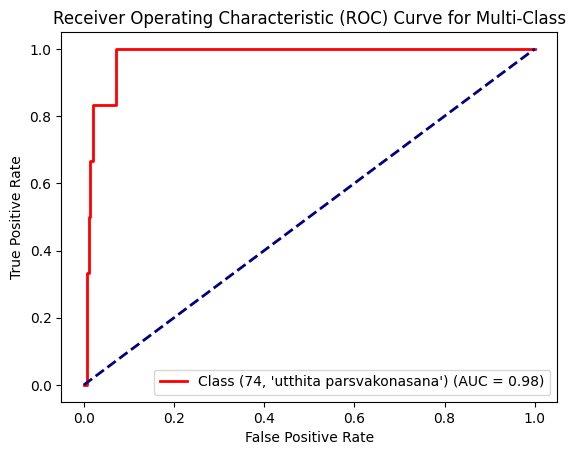

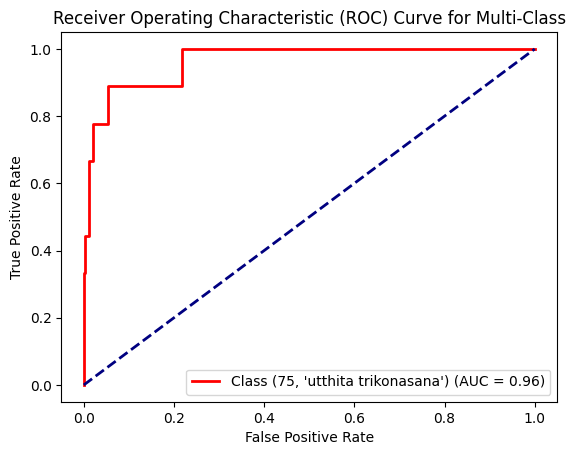

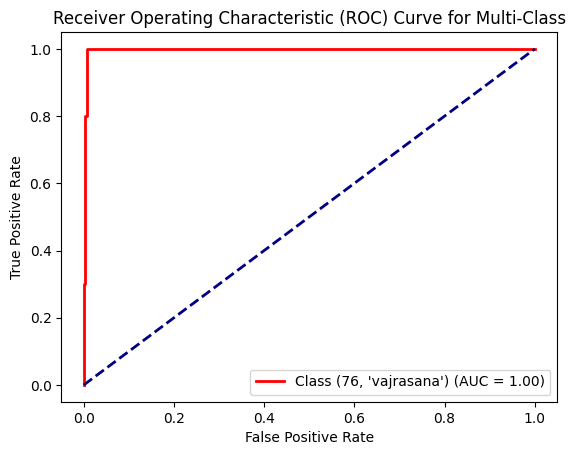

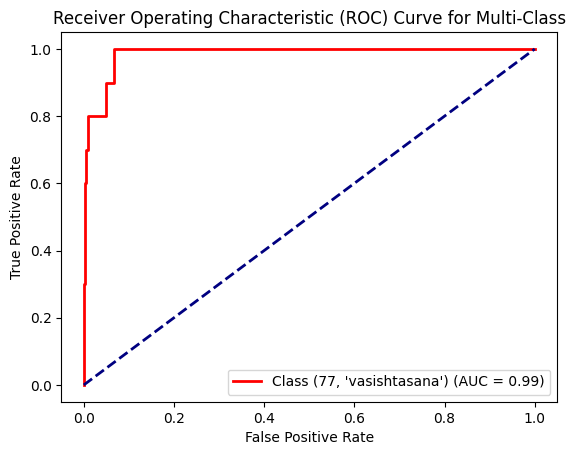

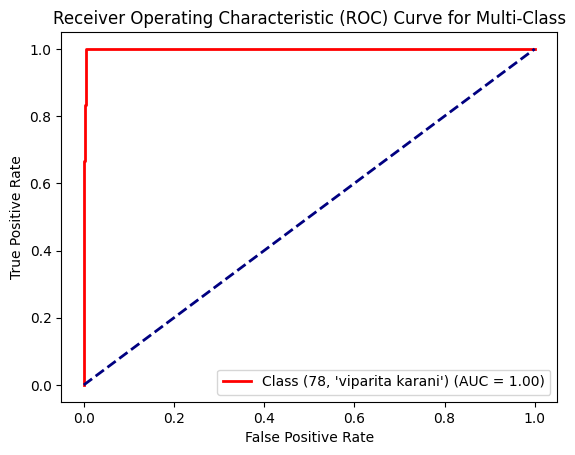

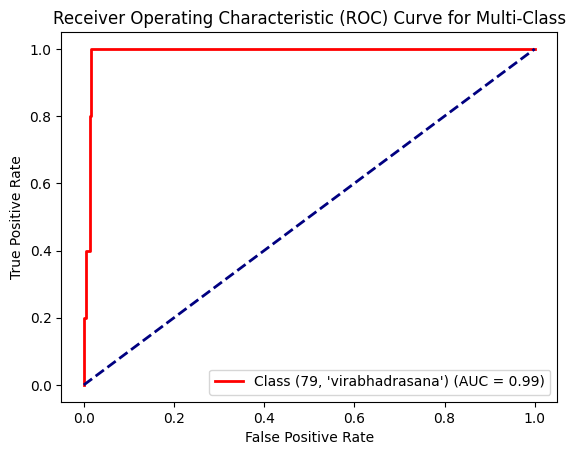

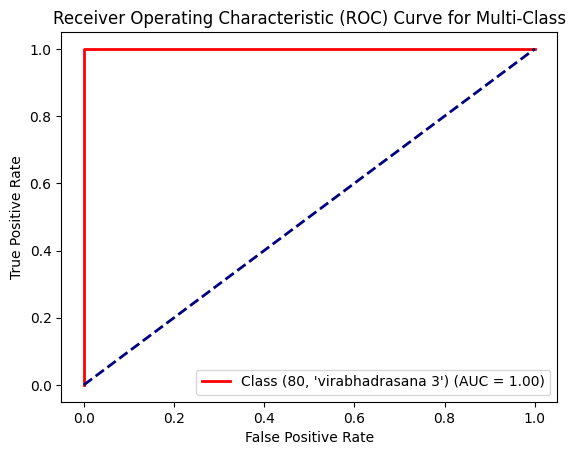

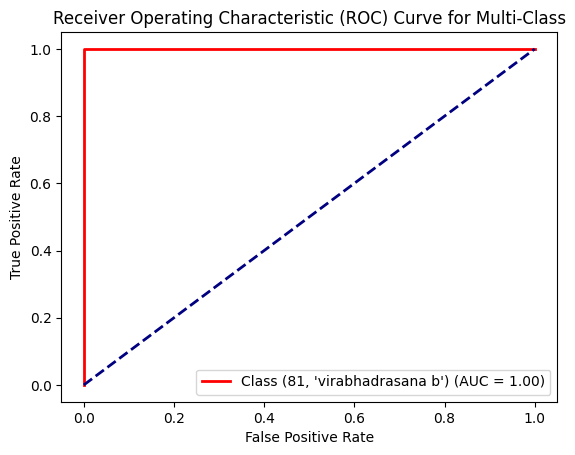

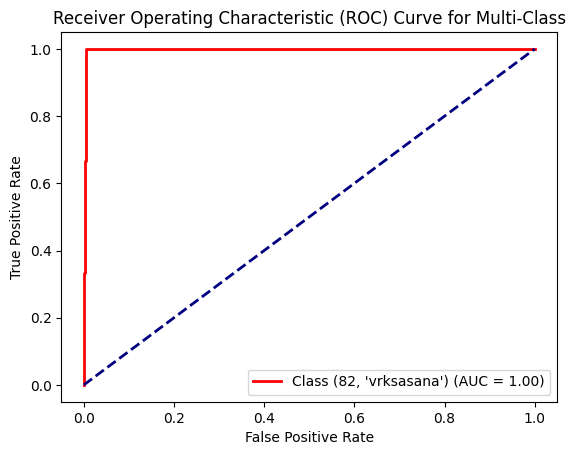

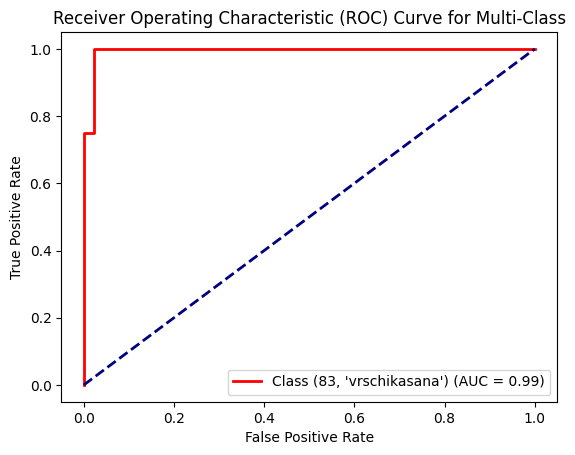

In [42]:
dn_path = '../models/dn_best.pkl'
model_prova = import_model(dn_path)
ROC_curve(model_prova, test_labels, labels_dict)

In [36]:
#plot_model(model_prova_arc, to_file='DNmodel_architecture.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


###### CNN

In [18]:
param_grid = {
    'model' : ['CNN'],
    'epochs' : [30],
    'batch_size': [8,16,32],
    'optimizer': ['adam','rmsprop','sgd']}

cnn_path = '../models/dn_best.pkl'
results_training2 = train_all(param_grid,train_data, train_labels, val_data, val_labels, test_data, test_labels, cnn_path)

number of epochs: 30, batch size: 8, optimizer: adam
Epoch 1/30


337/337 [==============================] - 11s 29ms/step - loss: 4.4547 - accuracy: 0.0137 - val_loss: 4.4328 - val_accuracy: 0.0069
Epoch 2/30
337/337 [==============================] - 11s 32ms/step - loss: 4.4292 - accuracy: 0.0126 - val_loss: 4.4327 - val_accuracy: 0.0069
Epoch 3/30
337/337 [==============================] - 10s 29ms/step - loss: 4.4041 - accuracy: 0.0237 - val_loss: 4.3964 - val_accuracy: 0.0191
Epoch 4/30
337/337 [==============================] - 10s 31ms/step - loss: 4.3428 - accuracy: 0.0289 - val_loss: 4.3526 - val_accuracy: 0.0225
Epoch 5/30
337/337 [==============================] - 11s 32ms/step - loss: 4.2864 - accuracy: 0.0278 - val_loss: 4.3086 - val_accuracy: 0.0277
Epoch 6/30
337/337 [==============================] - 10s 30ms/step - loss: 4.2124 - accuracy: 0.0482 - val_loss: 4.2727 - val_accuracy: 0.0381
Epoch 7/30
337/337 [==============================] - 10s 29ms/step - loss: 4.181

In [ ]:
save_training_results(results_training2)

In [ ]:
# model = import_model(cnn_path)
# ROC_curve(model, test_labels, labels_dict)

In [ ]:
param_grid = {
    'model' : ['CNN'],
    'epochs' : [50],
    'batch_size': [8,16,32],
    'optimizer': ['sgd']}

cnn_path = '../models/cnn_sgd50_best.pkl'
results_training3 = train_all(param_grid,train_data, train_labels, val_data, val_labels, test_data, test_labels, cnn_path)